In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/My\ Drive/eye_dataset/AMD_1.zip -d dataset

In [ ]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.5 MB/s eta 0:00:00


In [ ]:
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torch.nn as nn
from torchvision.transforms import v2
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.utils
import torch.utils.data
from PIL import Image
from torcheval.metrics.functional import multiclass_f1_score
from torcheval.metrics.functional import auc
from torcheval.metrics.functional import multiclass_confusion_matrix

from sklearn.manifold import TSNE
import seaborn as sns

from torchsummary import summary
from copy import deepcopy

***DATA PREPARATION***

In [ ]:
root = '/content/dataset/'

dataset = torch.tensor(())

labels = []

unic_shape = []

In [ ]:
size_height = 128
size_width = 256

In [ ]:
def image_preprocessing(path: os.path, label: int) -> None:
    transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        #v2.ToTensor(),
        v2.Grayscale(),
        v2.Resize((size_height, size_width))
    ])

    global dataset
    global labels

    img = imread(path)
    match img.shape:
        case (989, 1596, 3):
            dataset = torch.cat((dataset, transform(img[52:456, 577:1535])), 0)
            dataset = torch.cat((dataset, transform(img[497:901, 577:1535])), 0)
            labels.append(label)
            labels.append(label)
        case (1033, 1596, 3):
            dataset = torch.cat((dataset, transform(img[52:478, 601:1535])), 0)
            dataset = torch.cat((dataset, transform(img[519:945, 601:1535])), 0)
            labels.append(label)
            labels.append(label)
        case (580, 860, 3):
            dataset = torch.cat((dataset, transform(img)), 0)
            labels.append(label)
        case (580, 810, 3):
            dataset = torch.cat((dataset, transform(img)), 0)
            labels.append(label)
        case (1050, 1485, 3):
            dataset = torch.cat((dataset, transform(img[209:744, 346:1139])), 0)
            labels.append(label)

In [ ]:
for root, dirs, files in os.walk(root):

    if root.endswith('NORM'):
        for file in files:
            image_preprocessing(os.path.join(root, file), label = 0)

    if root.endswith('SUH'):
        for file in files:
            image_preprocessing(os.path.join(root, file), label = 1)
    if root.endswith('PROM'):
        for file in files:
            image_preprocessing(os.path.join(root, file), label = 2)

    if root.endswith('VL'):
        for file in files:
            image_preprocessing(os.path.join(root, file), label = 3)


In [ ]:
#Data preparation segment
images = dataset
labels = torch.LongTensor(labels)
print(dataset.shape)
dataset = TensorDataset(dataset, labels)

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
transform_train = v2.Compose(
    [
    #v2.RandomResizedCrop((size_height,size_width)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAdjustSharpness(1),
    AddGaussianNoise(0, 1)
    ])


transform_test = v2.Compose(
    [
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set, val_set, test_set = torch.utils.data.random_split(
    dataset=dataset, lengths=[0.7, 0.1, 0.2])

train_set.transform = transform_train
#val_set.transform = transform_test
#test_set.transform = transform_test

batch_size = 64
data_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
data_val = DataLoader(val_set, batch_size=batch_size, shuffle=False)
data_test = DataLoader(test_set, batch_size=batch_size, shuffle=False)

***CORE FUNCTIONS***

In [ ]:
def get_by_label(preds, labels, label):
    out = torch.tensor(())
    for i in range(len(preds)):
        if label == labels[i]:
            if out.shape[0] == 0:
                out = preds[i]
            else:
                out = torch.vstack((out, preds[i]))
    return out

In [ ]:
def train_classificator(model, opt, loss_fn, epochs, data_tr, data_val):
    history_train = []
    history_val = []
    best_val = 999999
    best_model = model
    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss_train = 0
        avg_loss_val = 0

        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.view((-1, 1, size_height, size_width)).to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad() # set parameter gradients to zero
            vector = model.get_vector(X_batch)
            Y_pred = model.forward_vector(vector)
            #Y_pred = model(X_batch)
            anomalyes = model.forward_anomalyes(X_batch, Y_batch)
            loss = loss_fn(Y_pred, Y_batch, anomalyes, vector) # criterion
            loss.backward()  # backward-pass
            opt.step()  # update weights
            avg_loss_train += loss / len(data_tr) # calculate loss to show the user
        print('loss train: %f' % avg_loss_train)
        history_train.append(avg_loss_train.item())

        model.eval()
        with torch.no_grad():
          if (epoch + 1) % 1 == 0:
              vectors = torch.tensor(())
              predicted = torch.tensor(())
              for X_batch, Y_batch in data_tr:
                  X_batch = X_batch.view((-1, 1, size_height, size_width)).to(device)

                  if vectors.shape[0] != 0:
                      vectors = torch.vstack((vectors, model.get_vector(X_batch)))
                  else:
                      vectors = model.get_vector(X_batch)
                  #predicted = torch.cat((predicted, torch.argmax(model.forward(X_batch), dim = 1)), dim = 0)
                  predicted = torch.cat((predicted, Y_batch), dim = 0)

              preds_norm = get_by_label(vectors, predicted, 0)
              preds_suh = get_by_label(vectors, predicted, 1)
              preds_prom = get_by_label(vectors, predicted, 2)
              preds_vl = get_by_label(vectors, predicted, 3)

              model.mean_norm, model.std_norm = torch.mean(preds_norm, dim = 0), torch.std(preds_norm, dim = 0)
              model.mean_suh, model.std_suh = torch.mean(preds_suh, dim = 0), torch.std(preds_suh, dim = 0)
              model.mean_prom, model.std_prom = torch.mean(preds_prom, dim = 0), torch.std(preds_prom, dim = 0)
              model.mean_vl, model.std_vl = torch.mean(preds_vl, dim = 0), torch.std(preds_vl, dim = 0)

          for X_batch, Y_batch in data_val:
            X_batch = X_batch.view((-1, 1, size_height, size_width)).to(device)
            Y_batch = Y_batch.to(device)
            vector = model.get_vector(X_batch)
            Y_pred = model.forward_vector(vector)
            #Y_pred = model(X_batch)
            anomalyes = model.forward_anomalyes(X_batch, Y_batch)
            loss = loss_fn(Y_pred, Y_batch, anomalyes, vector)
            avg_loss_val += loss / len(data_val)
        print('loss val: %f' % avg_loss_val)
        if avg_loss_val < best_val:
            best_val = avg_loss_val
            best_model = deepcopy(model.state_dict())
        history_val.append(avg_loss_val.item())

    return best_model, history_train, history_val

In [ ]:
def plot_divergence(latents, labels, title = 'TSNE-распределение точек латентных векторов'):
    import warnings
    warnings.filterwarnings("ignore")

    latents_tsne = TSNE(n_components=2).fit_transform(latents)
    fig, ax = plt.subplots()
    sns.set(rc={'figure.figsize': (15, 8)}, font_scale=1.2, style='darkgrid')
    sns.scatterplot(x = latents_tsne[:, 0],
                    y = latents_tsne[:, 1],
                    hue=labels,
                    palette='bright',
                    style=labels)
    ax.set_title(title, fontsize =20, color = 'black', fontfamily = 'sans-serif', fontstyle = 'italic', pad = 15)
    ax.set_xlabel('X', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
    ax.set_ylabel('Y', fontsize =20, color = 'purple', fontfamily = 'sans-serif', fontstyle = 'italic')
    plt.show()

In [ ]:
def plot_distribution(model):
    def get_gausian(x, mean, variance):
      f = np.exp(-np.square(x-mean)/2*variance)/(np.sqrt(2*np.pi*variance))
      return f

    x = np.arange(-1, 1, 0.01)
    norm = get_gausian(x, model.mean_norm, model.std_norm)
    suh = get_gausian(x, model.mean_suh, model.std_suh)
    prom = get_gausian(x, model.mean_prom, model.std_prom)
    vl = get_gausian(x, model.mean_vl, model.std_vl)

    plt.plot(x, norm, label = 'norm', color = 'green')
    plt.plot(x, suh, label = 'suh', color = 'yellow')
    plt.plot(x, prom, label = 'prom', color = 'red')
    plt.plot(x, vl, label = 'vl', color = 'black')
    plt.legend()
    plt.show()

In [ ]:
def test(model, loss_fn, data_test):
  avg_loss_test = 0
  model.eval()
  running_corrects = 0
  processed_size = 0
  cm = torch.zeros((model.num_classes, model.num_classes))
  vectors = torch.tensor(()).to(device)
  score_y = torch.tensor(()).to(device)
  score_pred = torch.tensor(()).to(device)

  with torch.no_grad():
    for X_batch, target in data_test:
      X_batch = X_batch.view((-1, 1, size_height, size_width)).to(device)
      target = target.to(device)
      vectors = torch.cat((vectors, model.get_vector(X_batch)))
      Y_pred = model.forward(X_batch)

      score_pred = torch.cat((score_pred, Y_pred))
      score_y = torch.cat((score_y, target))

      preds = torch.argmax(Y_pred, dim = 1)
      cm += multiclass_confusion_matrix(preds, target, num_classes = model.num_classes).cpu()
      running_corrects += torch.sum(preds == target)
      processed_size += target.size(0)

  acc = (running_corrects/processed_size).item()
  print('Accuracy: ', acc)

  print("confusion Matrix: \n", cm)

  f1_score = multiclass_f1_score(score_pred, score_y, num_classes = model.num_classes)
  print("F1 score: ", f1_score.item())

  max_values, _ = torch.max(score_pred, dim = 1)
  print("Area under the curve: ", auc(max_values, score_y, reorder = True).item())

  anomalyes = model.anomaly_check(vectors, score_y, std_coef = 3)
  print("Percent of anomalyes:", (1- torch.sum(anomalyes).item() / len(anomalyes)) * 100)


  vectors = vectors.cpu()
  score_y = score_y.cpu()
  score_pred = torch.argmax(score_pred, dim = 1).cpu()
  plot_divergence(vectors, score_y, 'Распределение векторов, где цвет - таргет данные')
  plot_divergence(vectors, score_pred, 'Распределение векторов, где цвет - предсказанные данные')
  #plot_distribution(model)

In [ ]:
def anomaly_loss(pred, target, anomalyes, vector):
    loss_cross = nn.CrossEntropyLoss()
    loss_anomalyes = nn.BCELoss()
    loss_distance = nn.MSELoss()
    return 1 * loss_cross(pred, target)
    + 32 * loss_anomalyes(anomalyes, torch.ones_like(anomalyes))
    + 32 * loss_distance(vector, torch.ones_like(vector)*target)

***SIMPLE LINEAR + ACTIVATION MAPS***

In [ ]:
class LinearMaps(nn.Module):

    def __init__(self, num_classes = 4, vector_size = 32):
        self.num_classes = num_classes
        self.vector_size = vector_size
        self.mean_norm, self.std_norm = torch.rand(self.vector_size * 5).to(device), torch.rand(self.vector_size * 5).to(device)
        self.mean_suh, self.std_suh = torch.rand(self.vector_size * 5).to(device), torch.rand(self.vector_size * 5).to(device)
        self.mean_prom, self.std_prom = torch.rand(self.vector_size * 5).to(device), torch.rand(self.vector_size * 5).to(device)
        self.mean_vl, self.std_vl = torch.rand(self.vector_size * 5).to(device), torch.rand(self.vector_size * 5).to(device)

        super().__init__()
        enc1_in = 1
        enc1_hid = 4
        enc1_out = 4
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels=enc1_in, out_channels=enc1_hid, kernel_size=1),
            nn.Conv2d(in_channels=enc1_hid, out_channels=enc1_out, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        enc2_in = enc1_out
        enc2_hid = 4
        enc2_out = 8
        self.enc2 = nn.Sequential(
            nn.Conv2d(in_channels=enc2_in, out_channels=enc2_hid, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = enc2_hid, out_channels=enc2_out, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        enc3_in = enc2_out
        enc3_hid = 16
        enc3_out = 16
        self.enc3 = nn.Sequential(
            nn.Conv2d(in_channels = enc3_in, out_channels = enc3_hid, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels = enc3_hid, out_channels = enc3_out, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        enc4_in = enc3_out
        enc4_hid = 32
        enc4_out = 32
        self.enc4 = nn.Sequential(
            nn.Conv2d(in_channels=enc4_in, out_channels=enc4_hid, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=enc4_hid, out_channels=enc4_out, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        enc5_in = enc4_out
        enc5_hid = 64
        enc5_out = 128
        self.enc5 = nn.Sequential(
            nn.Conv2d(in_channels=enc5_in, out_channels=enc5_hid, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=enc5_hid, out_channels=enc5_out, kernel_size=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.vectorize0 = nn.Sequential(
            nn.Linear(in_features = int(size_height*size_width/4), out_features = self.vector_size),
            nn.ReLU(),
            nn.Linear(in_features = self.vector_size, out_features = self.vector_size),
            #nn.BatchNorm1d(self.vector_size)
        )

        self.vectorize1 = nn.Sequential(
            nn.Linear(in_features = int(size_height*size_width/4) * enc1_out, out_features = self.vector_size),
            nn.ReLU(),
            nn.Linear(in_features = self.vector_size, out_features = self.vector_size),
            #nn.BatchNorm1d(self.vector_size)
        )

        self.vectorize2 = nn.Sequential(
            nn.Linear(in_features = int(size_height*size_width/16) * enc2_out, out_features = self.vector_size),
            nn.ReLU(),
            nn.Linear(in_features = self.vector_size, out_features = self.vector_size),
            #nn.BatchNorm1d(self.vector_size)
        )

        self.vectorize3 = nn.Sequential(
            nn.Linear(in_features = int(size_height*size_width/64) * enc3_out, out_features = self.vector_size),
            nn.ReLU(),
            nn.Linear(in_features = self.vector_size, out_features = self.vector_size),
            #nn.BatchNorm1d(self.vector_size)
        )

        self.vectorize4 = nn.Sequential(
            nn.Linear(in_features = int(size_height*size_width/256) * enc4_out, out_features = self.vector_size),
            nn.ReLU(),
            nn.Linear(in_features = self.vector_size, out_features = self.vector_size),
            #nn.BatchNorm1d(self.vector_size)
        )

        self.vectorize5 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = int(size_height*size_width/1024) * enc5_out, out_features = self.vector_size),
            nn.ReLU(),
            nn.Linear(in_features = self.vector_size, out_features = self.vector_size)
        )

        self.classificator = nn.Linear(self.vector_size * 5, self.num_classes)


    def get_vector(self, x):

        enc1 = self.enc1(x)
        vec1 = self.vectorize1(enc1.view(x.shape[0], -1))

        enc2 = self.enc2(enc1)
        vec2 = self.vectorize2(enc2.view(x.shape[0], -1))

        enc3 = self.enc3(enc2)
        vec3 = self.vectorize3(enc3.view(x.shape[0], -1))

        enc4 = self.enc4(enc3)
        vec4 = self.vectorize4(enc4.view(x.shape[0], -1))

        enc5 = self.enc5(enc4)
        vec5 = self.vectorize5(enc5.view(x.shape[0], -1))

        #vec_full = self.vectorize(enc5.view(x.shape[0], -1))
        vec_full = torch.cat((vec1, vec2, vec3, vec4, vec5), dim = 1)
        return vec_full

    def forward_anomalyes(self, x, target, std_coef = 0.5):
        anomalyes = torch.tensor(())
        vector = self.get_vector(x)
        for i in range(x.shape[0]):
            mean_vector, std_vector = torch.tensor(()), torch.tensor(())
            match target[i]:
                case 0:
                    mean_vector, std_vector = self.mean_norm, self.std_norm
                case 1:
                    mean_vector, std_vector = self.mean_suh, self.std_suh
                case 2:
                    mean_vector, std_vector = self.mean_prom, self.std_prom
                case 3:
                    mean_vector, std_vector = self.mean_vl, self.std_vl
            anomaly = (torch.abs(vector[i] - mean_vector) <= std_coef * std_vector).clone().long()
            #anomaly = torch.tensor(torch.abs(vector[i] - mean_vector) <= std_coef * std_vector).clone().detach().long()
            if anomalyes.shape[0] == 0:
                anomalyes = anomaly
            else:
                anomalyes = torch.vstack((anomalyes, anomaly))
        return anomalyes


    def anomaly_check(self, latent_vector, predicted_label, std_coef = 3):
        anomalyes = torch.tensor(()).to(device)
        for i in range(latent_vector.shape[0]):
            mean_vector, std_vector = torch.tensor(()), torch.tensor(())
            match predicted_label[i]:
                case 0:
                    mean_vector, std_vector = self.mean_norm, std_coef * self.std_norm
                case 1:
                    mean_vector, std_vector = self.mean_suh, std_coef * self.std_suh
                case 2:
                    mean_vector, std_vector = self.mean_prom, std_coef * self.std_prom
                case 3:
                    mean_vector, std_vector = self.mean_vl, std_coef * self.std_vl
            anomaly = torch.tensor(torch.all(torch.abs(latent_vector[i] - mean_vector) <= std_vector)).reshape(1)
            anomalyes = torch.cat((anomalyes, anomaly), dim = 0)
        return anomalyes

    def forward_image(self, x):
        vector = self.get_vector(x).view(x.shape[0], -1, int(size_height / 8), int(size_width / 8))
        img = self.decoder(vector)
        return img

    def forward_vector(self, vector):
        out = self.classificator(vector.view(vector.size(0), -1))
        return out

    def forward(self, x):
        vector = self.get_vector(x)
        vector = vector.view(vector.size(0), -1)

        out = self.classificator(vector)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_maps = LinearMaps(vector_size = 16).to(device)
best_model  = model_maps
optim = torch.optim.Adam(model_maps.parameters(), lr = 3e-4)

summary(model_maps, (1, size_height, size_width))
None

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 64]               8
            Conv2d-2            [-1, 4, 32, 64]             148
              ReLU-3            [-1, 4, 32, 64]               0
         MaxPool2d-4            [-1, 4, 16, 32]               0
            Linear-5                    [-1, 8]          16,392
              ReLU-6                    [-1, 8]               0
            Linear-7                    [-1, 8]              72
            Conv2d-8            [-1, 4, 16, 32]              20
              ReLU-9            [-1, 4, 16, 32]               0
           Conv2d-10            [-1, 8, 16, 32]             296
             ReLU-11            [-1, 8, 16, 32]               0
        MaxPool2d-12             [-1, 8, 8, 16]               0
           Linear-13                    [-1, 8]           8,200
             ReLU-14                   

In [ ]:
criterion = anomaly_loss

In [ ]:
best_model, tr_graph, val_graph = train_classificator(model_maps, optim, criterion, 100, data_train, data_val)

* Epoch 1/100
loss train: 0.341102
loss val: 0.459349
* Epoch 2/100
loss train: 0.328028
loss val: 0.452291
* Epoch 3/100
loss train: 0.322224
loss val: 0.471787
* Epoch 4/100
loss train: 0.327611
loss val: 0.472049
* Epoch 5/100
loss train: 0.332376
loss val: 0.486775
* Epoch 6/100
loss train: 0.322800
loss val: 0.455720
* Epoch 7/100
loss train: 0.306019
loss val: 0.456561
* Epoch 8/100
loss train: 0.335383
loss val: 0.466098
* Epoch 9/100
loss train: 0.307010
loss val: 0.454381
* Epoch 10/100
loss train: 0.297973
loss val: 0.456867
* Epoch 11/100
loss train: 0.291195
loss val: 0.442161
* Epoch 12/100
loss train: 0.286549
loss val: 0.456199
* Epoch 13/100
loss train: 0.290002
loss val: 0.430539
* Epoch 14/100
loss train: 0.295631
loss val: 0.443887
* Epoch 15/100
loss train: 0.295631
loss val: 0.448734
* Epoch 16/100
loss train: 0.284845
loss val: 0.434953
* Epoch 17/100
loss train: 0.289532
loss val: 0.452146
* Epoch 18/100
loss train: 0.268119
loss val: 0.426083
* Epoch 19/100
loss

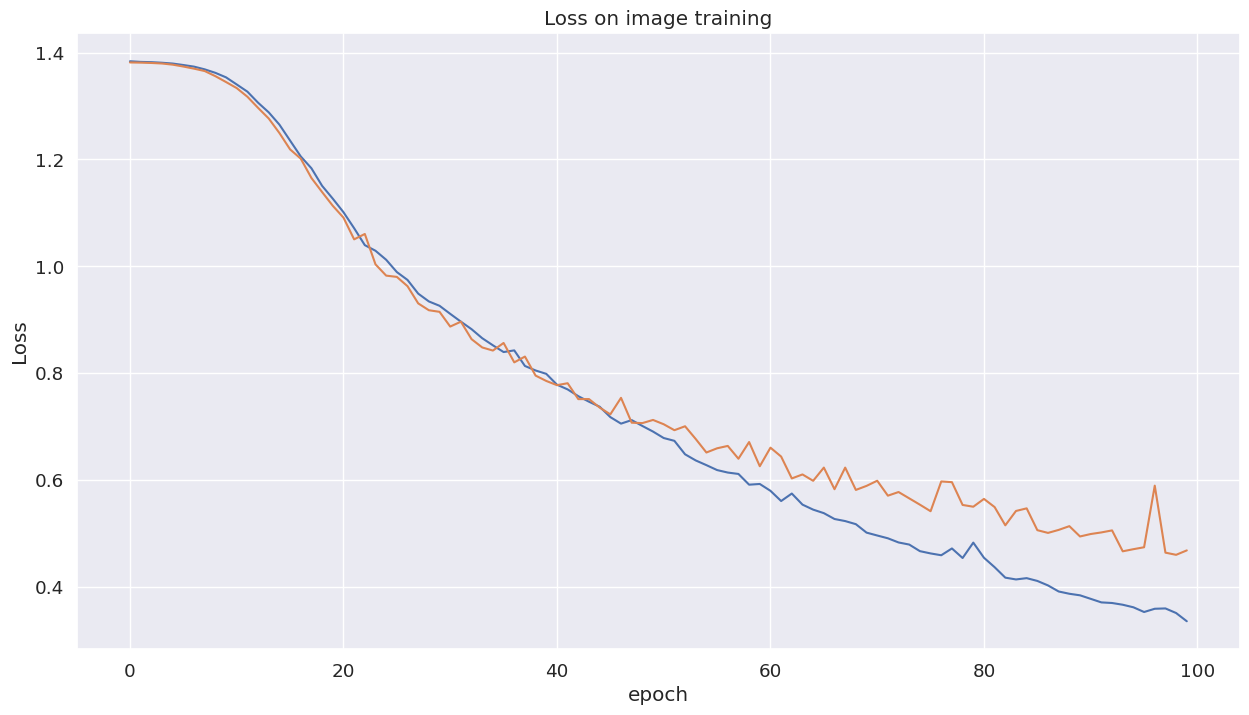

In [ ]:
#fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.title("Loss on image training")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.plot(tr_graph)
plt.plot(val_graph)

Accuracy:  0.7992633581161499
confusion Matrix: 
 tensor([[101.,  26.,   5.,   4.],
        [ 10.,  94.,  13.,  10.],
        [  2.,  18., 102.,   4.],
        [  1.,  13.,   3., 137.]])
F1 score:  0.7992633581161499
Area under the curve:  87.67424774169922
Percent of anomalyes: 4.41988950276243


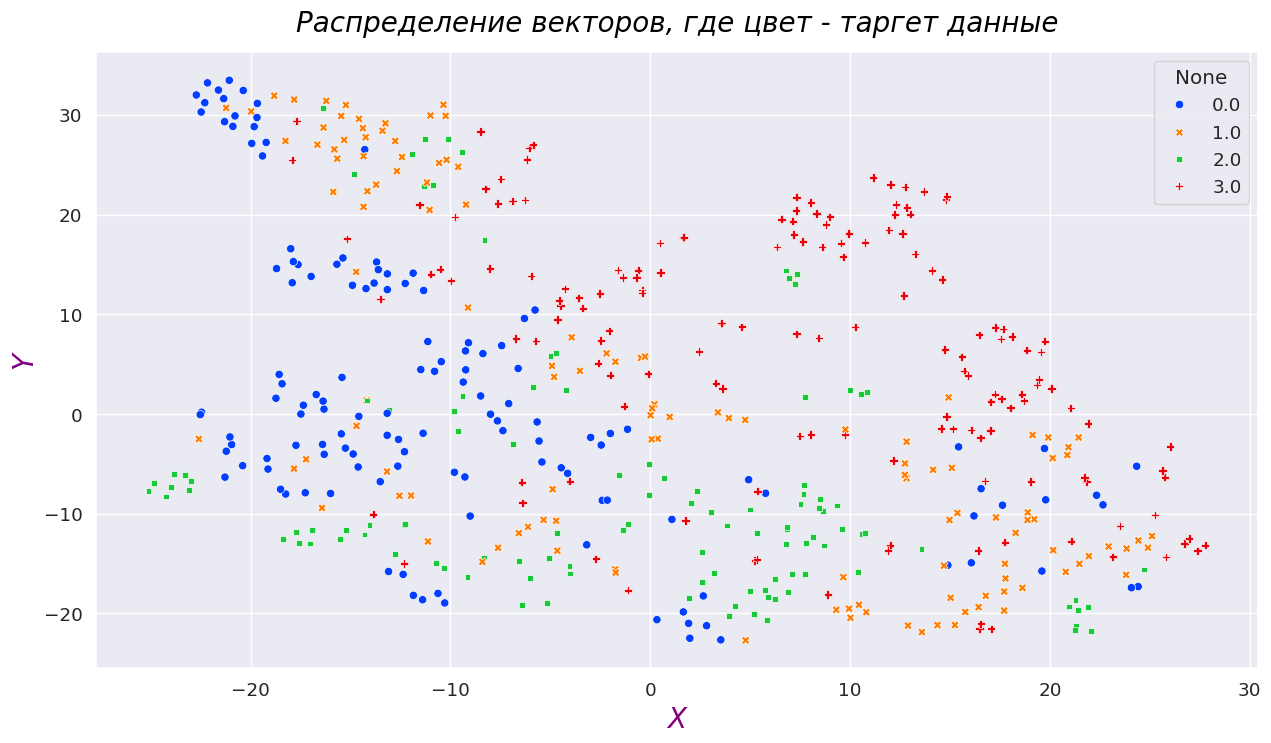

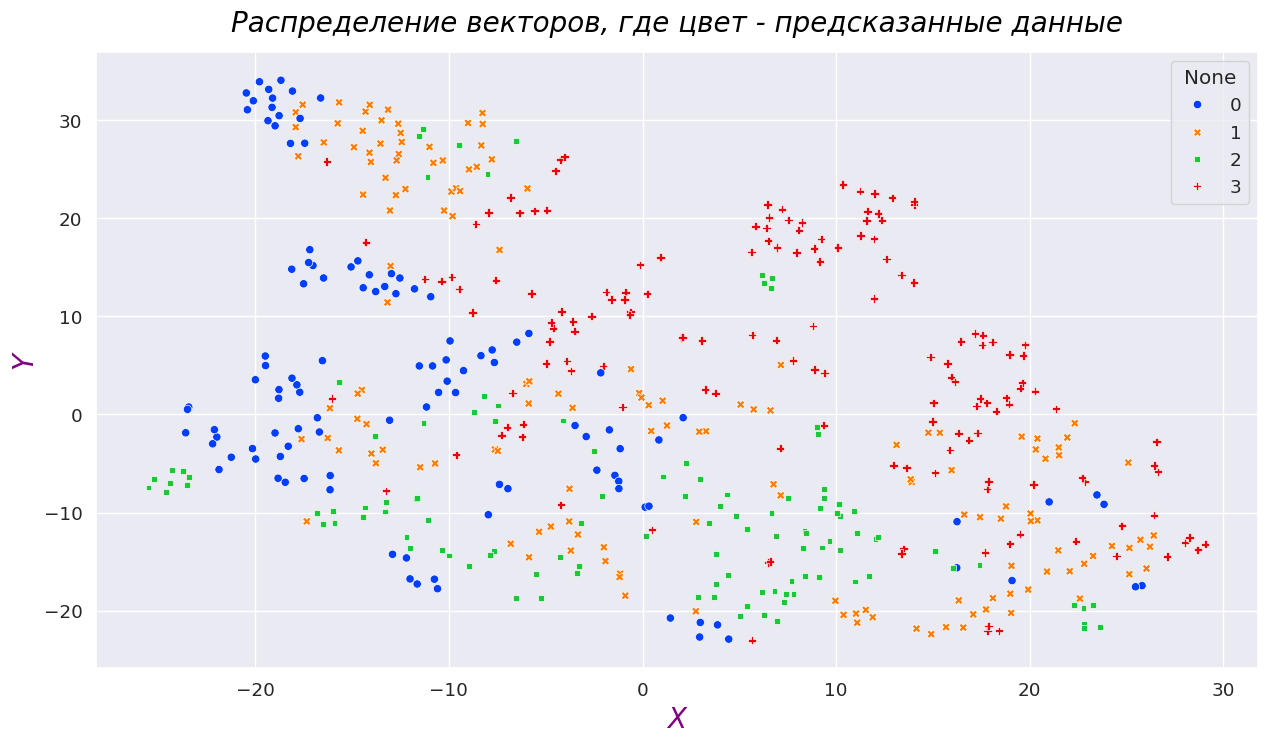

In [ ]:
test(model_maps, criterion, data_test)

Accuracy:  0.8792017102241516
confusion Matrix: 
 tensor([[402.,  46.,   7.,   4.],
        [ 18., 466.,  23.,  12.],
        [  2.,  68., 340.,   4.],
        [  1.,  33.,  12., 466.]])
F1 score:  0.8792017102241516
Area under the curve:  86.2754898071289
Percent of anomalyes: 3.256302521008403


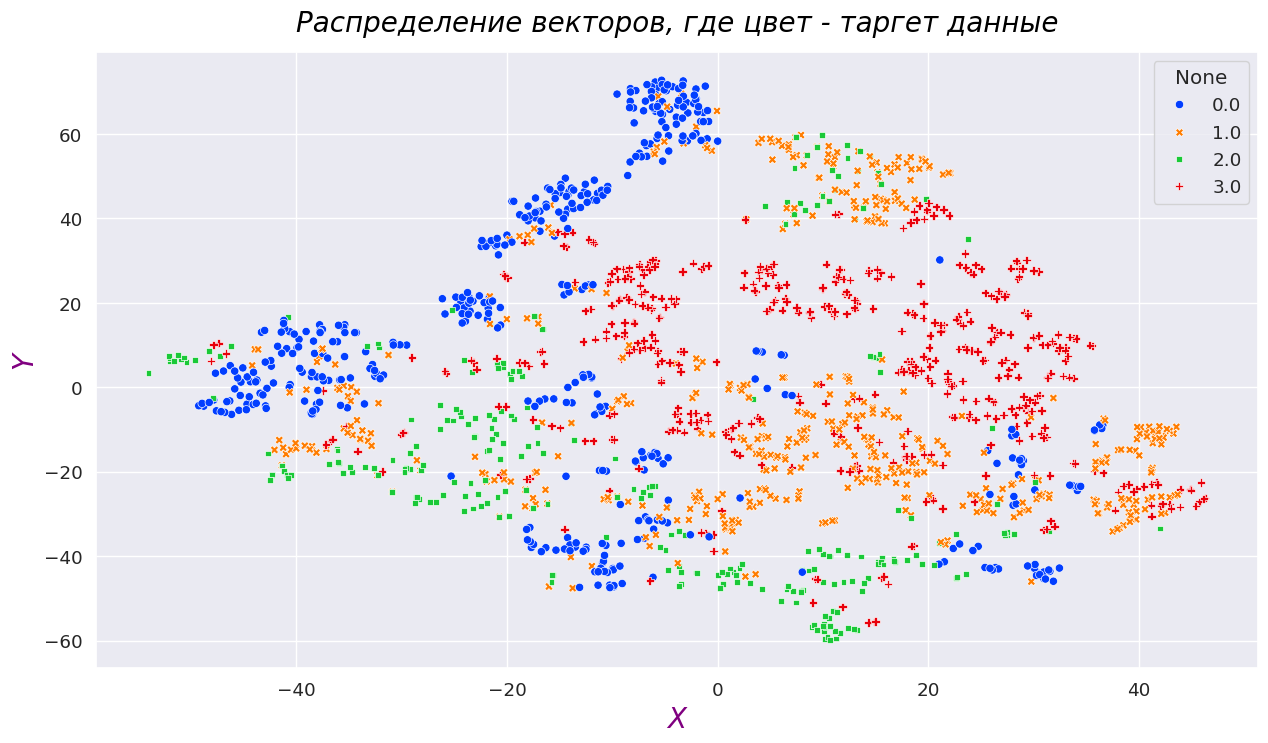

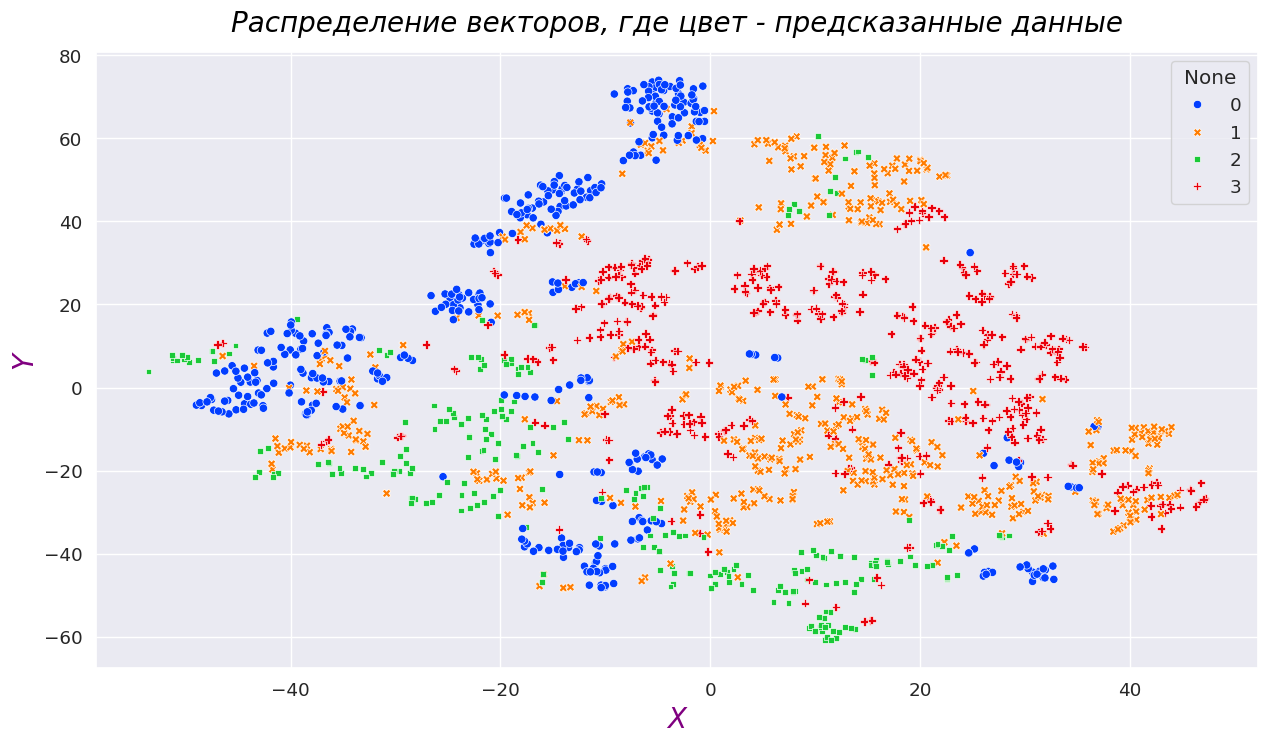

In [ ]:
test(model_maps, criterion, data_train)

In [ ]:
model_maps_best = LinearMaps(vector_size = 8).to(device)
model_maps_best.load_state_dict(best_model)

<All keys matched successfully>

Accuracy:  0.7274401783943176
confusion Matrix: 
 tensor([[ 86.,  24.,   6.,   3.],
        [  8., 108.,  20.,   7.],
        [  4.,  24.,  87.,   5.],
        [  8.,  28.,  11., 114.]])
F1 score:  0.7274401187896729
Area under the curve:  56.141517639160156
Percent of anomalyes: 100.0


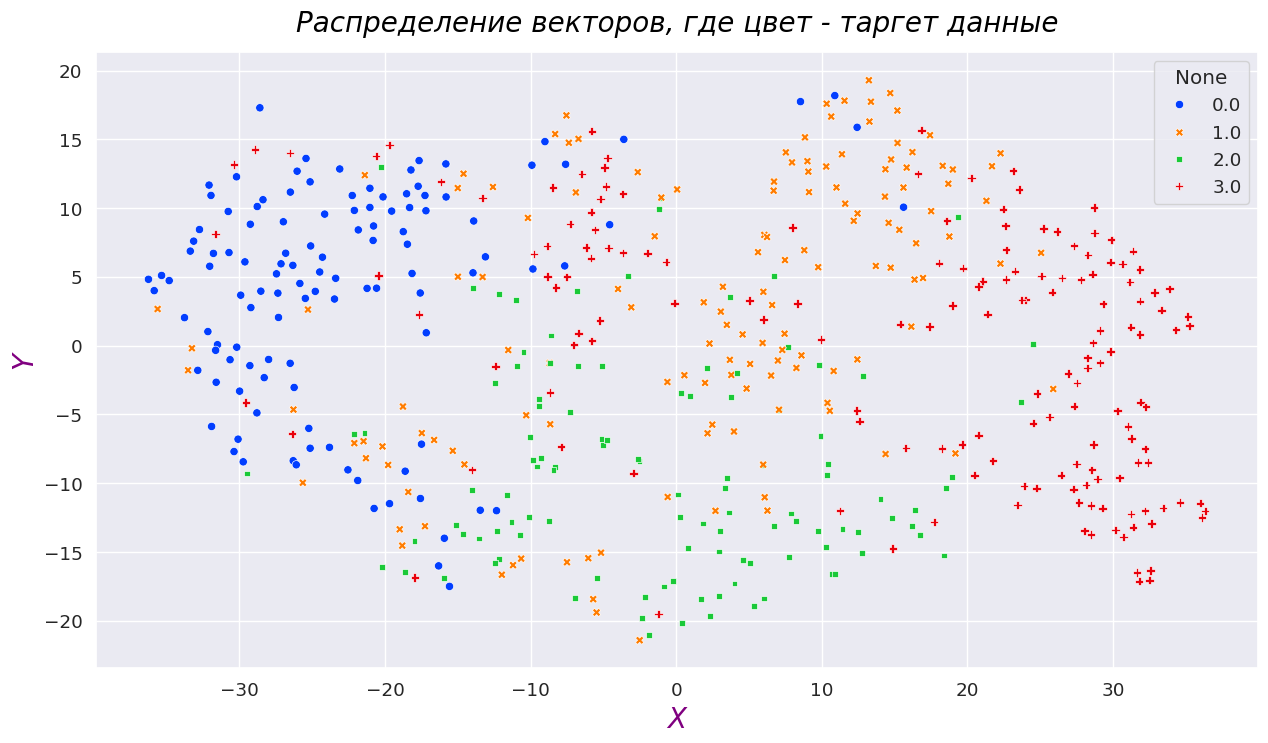

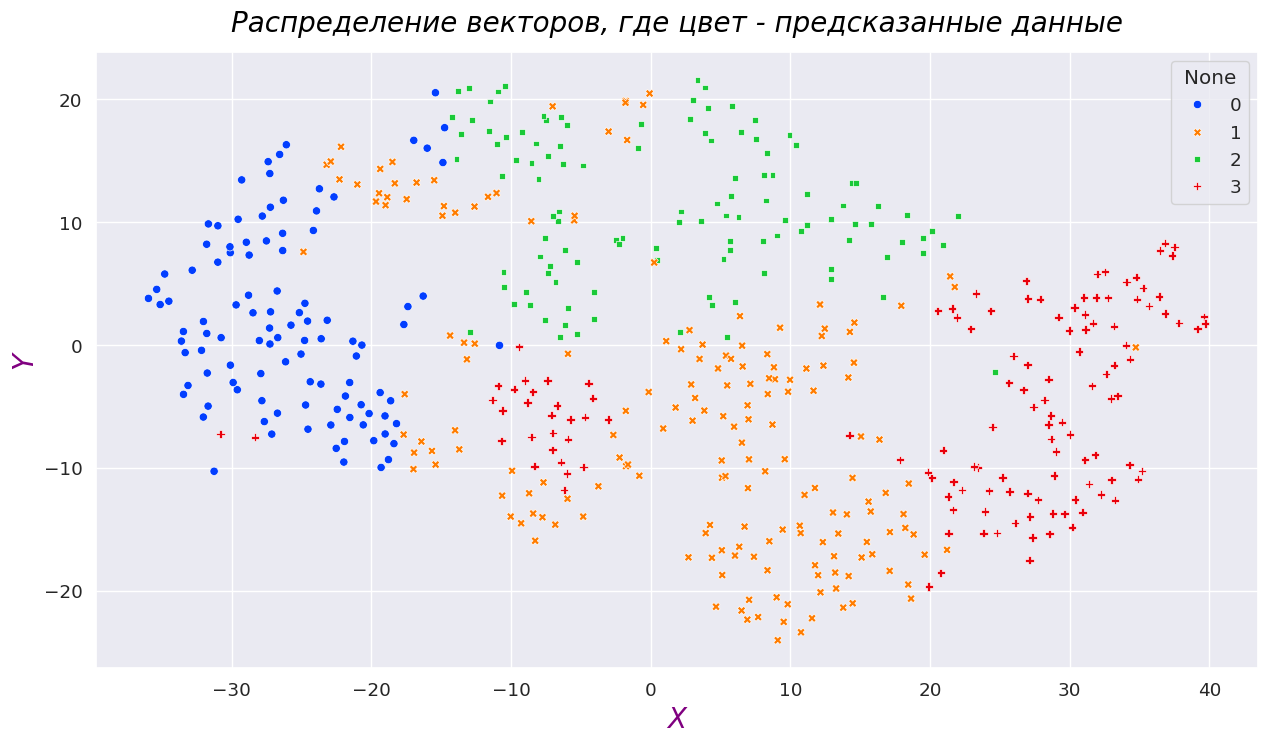

In [ ]:
test(model_maps_best, criterion, data_test)

Accuracy:  0.8450630903244019
confusion Matrix: 
 tensor([[426.,  30.,  16.,   0.],
        [ 21., 428.,  36.,  19.],
        [  6.,  64., 346.,   3.],
        [  6.,  68.,  26., 409.]])
F1 score:  0.8450630307197571
Area under the curve:  56.94685363769531
Percent of anomalyes: 100.0


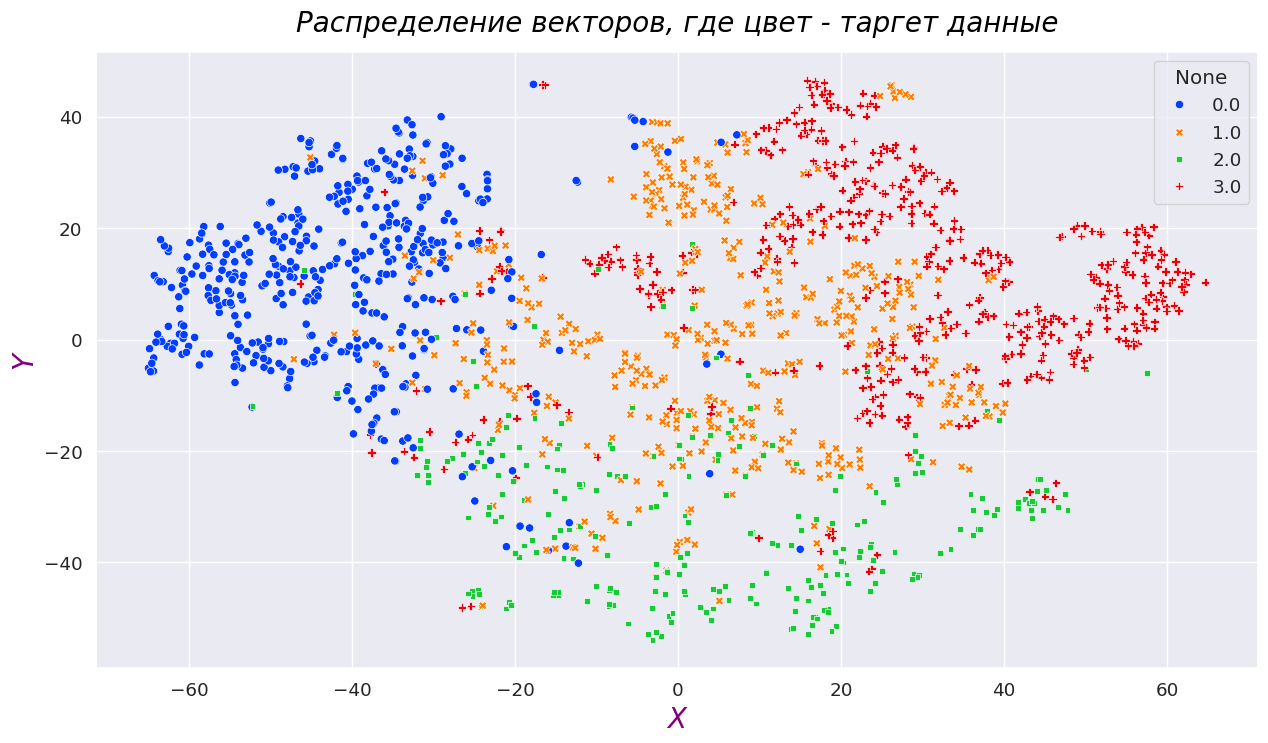

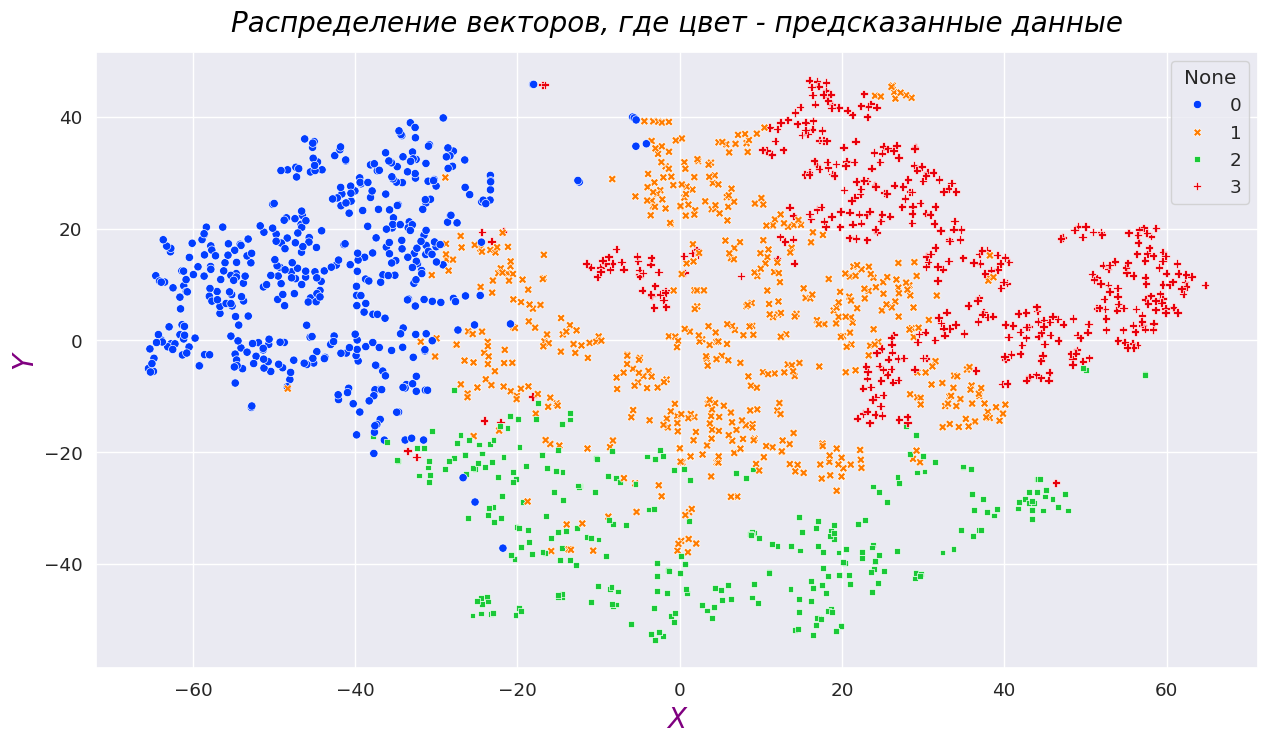

In [ ]:
test(model_maps_best, criterion, data_train)